# Advanced CNN for High-Accuracy CIFAR-10 Classification

This notebook builds and trains a deeper, VGG-style Convolutional Neural Network to achieve over **80% accuracy** on the CIFAR-10 dataset. It uses strong data augmentation, batch normalization, dropout, and a learning rate scheduler to maximize performance.

## 1. Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm # For progress bars

## 2. Data Loading and Augmentation

We'll use strong data augmentation to prevent overfitting and help the model generalize. The test set is only normalized.

In [2]:
data_path = './data'

# Strong augmentation for the training data
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 specific means/stds
])

# Only normalization for the test data
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Create Datasets and DataLoaders
train_data = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root=data_path, train=False, download=True, transform=test_transforms)

BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

classes = train_data.classes
print(f"Classes: {classes}")
print(f"Training data batches: {len(train_loader)}")
print(f"Test data batches: {len(test_loader)}")

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training data batches: 391
Test data batches: 79


## 3. Advanced Model Architecture

This model is inspired by VGGNet. It uses multiple blocks of `Conv2d` -> `BatchNorm2d` -> `ReLU` layers, followed by a `MaxPool2d` layer. This deeper structure allows it to learn a richer hierarchy of features.

In [3]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Output: 16x16x64
        )

        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Output: 8x8x128
        )

        # Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Output: 4x4x256
        )

        # Classifier (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

## 4. Training Setup

We define the model, optimizer (`Adam`), loss function (`CrossEntropyLoss`), and a **Learning Rate Scheduler**. The scheduler will reduce the learning rate during training, which helps the model converge to a better solution.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = AdvancedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler: Reduce LR by a factor of 0.1 every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Using device: cuda


## 5. The Training and Evaluation Loop

We'll train for 25 epochs and keep track of the training loss and test accuracy at each epoch to visualize the learning process.

In [5]:
EPOCHS = 25
history = {'train_loss': [], 'test_accuracy': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'loss': running_loss / len(progress_bar)})

    train_loss = running_loss / len(train_loader)
    history['train_loss'].append(train_loss)

    # --- Evaluation Phase ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    history['test_accuracy'].append(test_accuracy)

    # Step the scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.5f}")

Epoch 1/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/25 -> Train Loss: 1.8086, Test Accuracy: 50.82%, LR: 0.00100


Epoch 2/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/25 -> Train Loss: 1.3265, Test Accuracy: 59.09%, LR: 0.00100


Epoch 3/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/25 -> Train Loss: 1.0955, Test Accuracy: 69.18%, LR: 0.00100


Epoch 4/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/25 -> Train Loss: 0.9628, Test Accuracy: 72.76%, LR: 0.00100


Epoch 5/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/25 -> Train Loss: 0.8696, Test Accuracy: 73.88%, LR: 0.00100


Epoch 6/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/25 -> Train Loss: 0.7766, Test Accuracy: 76.18%, LR: 0.00100


Epoch 7/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/25 -> Train Loss: 0.7203, Test Accuracy: 75.49%, LR: 0.00100


Epoch 8/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/25 -> Train Loss: 0.6645, Test Accuracy: 80.45%, LR: 0.00100


Epoch 9/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/25 -> Train Loss: 0.6145, Test Accuracy: 82.75%, LR: 0.00100


Epoch 10/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/25 -> Train Loss: 0.5697, Test Accuracy: 82.79%, LR: 0.00010


Epoch 11/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/25 -> Train Loss: 0.4635, Test Accuracy: 86.57%, LR: 0.00010


Epoch 12/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/25 -> Train Loss: 0.4310, Test Accuracy: 86.77%, LR: 0.00010


Epoch 13/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/25 -> Train Loss: 0.4169, Test Accuracy: 87.03%, LR: 0.00010


Epoch 14/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/25 -> Train Loss: 0.4023, Test Accuracy: 87.31%, LR: 0.00010


Epoch 15/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/25 -> Train Loss: 0.3951, Test Accuracy: 87.53%, LR: 0.00010


Epoch 16/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/25 -> Train Loss: 0.3852, Test Accuracy: 87.55%, LR: 0.00010


Epoch 17/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/25 -> Train Loss: 0.3763, Test Accuracy: 87.61%, LR: 0.00010


Epoch 18/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/25 -> Train Loss: 0.3692, Test Accuracy: 87.37%, LR: 0.00010


Epoch 19/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/25 -> Train Loss: 0.3625, Test Accuracy: 87.91%, LR: 0.00010


Epoch 20/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/25 -> Train Loss: 0.3531, Test Accuracy: 87.88%, LR: 0.00001


Epoch 21/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/25 -> Train Loss: 0.3416, Test Accuracy: 88.11%, LR: 0.00001


Epoch 22/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/25 -> Train Loss: 0.3348, Test Accuracy: 88.04%, LR: 0.00001


Epoch 23/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/25 -> Train Loss: 0.3345, Test Accuracy: 88.20%, LR: 0.00001


Epoch 24/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/25 -> Train Loss: 0.3341, Test Accuracy: 88.18%, LR: 0.00001


Epoch 25/25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/25 -> Train Loss: 0.3344, Test Accuracy: 88.23%, LR: 0.00001


## 6. Results and Visualization

Let's plot the training loss and test accuracy over the epochs. A good model will show a decreasing loss and an increasing (and stabilizing) accuracy.

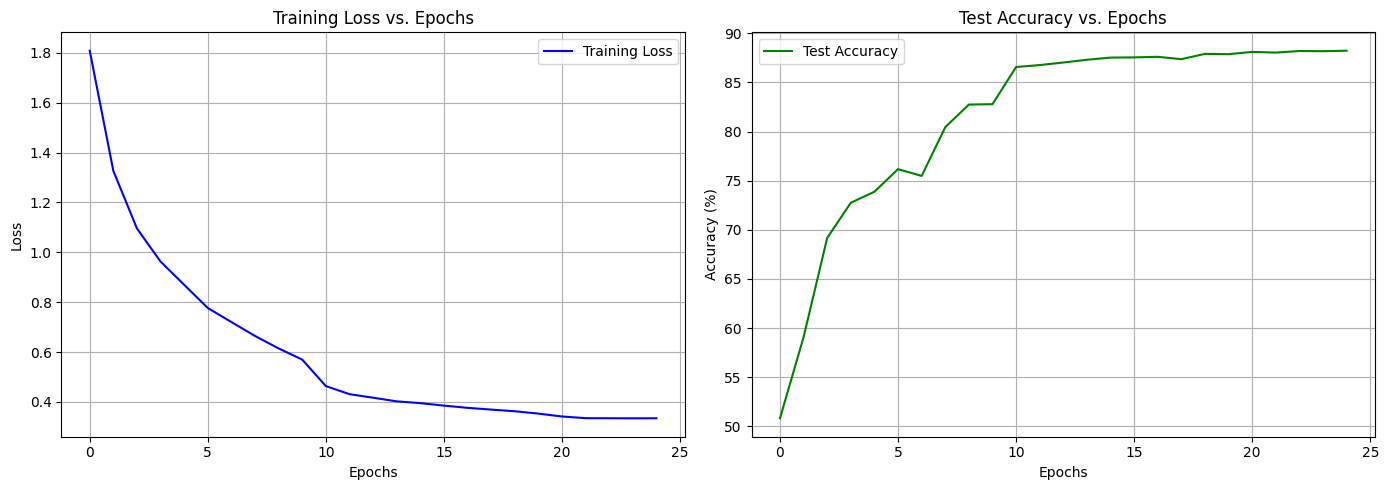


Final Model Accuracy: 88.23%


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training Loss
ax1.plot(history['train_loss'], label='Training Loss', color='blue')
ax1.set_title('Training Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Test Accuracy
ax2.plot(history['test_accuracy'], label='Test Accuracy', color='green')
ax2.set_title('Test Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

final_accuracy = history['test_accuracy'][-1]
print(f"\nFinal Model Accuracy: {final_accuracy:.2f}%")